In [ ]:
import pandas as pd
import numpy as np

import itertools
import collections
import re
import logging
from re import sub
from keybert import KeyBERT
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk import skipgrams

from fuzzywuzzy import process, fuzz
from networkx.algorithms.community.centrality import girvan_newman

# Import and download stopwords from NLTK.
nltk.download('stopwords')  # Download stopwords list.
stopwords = set(nltk.corpus.stopwords.words("english"))

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman
from itertools import chain, combinations

import string
import gc
import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_excel('review_summary.xlsx', engine='openpyxl')
#data

In [3]:
len(data['Authors'].unique())

46

In [4]:
#if re.findall(r'\b([A-Z]{1}[.]$)', text):
    # Swap the first and second words separated by one space
    #text = re.sub(r'(\S+) (\S+)', r'\2 \1', text) 

def change_auth(text):
    text = text.replace('\n', ' ')
    text = text.replace('and ', '')
    text = re.sub(' +', ' ', text)
    words = text.split(',')
    result = ''
    for word in words:
        word = word.strip()
        last_n = word.split()[-1]
        first_n = ' '.join(word.split(' ')[:-1])
        first_n = re.sub('-', ' ', first_n)
        first_n = '. '.join([c for c in first_n if c.isupper()]) + '.'
        word = first_n + ' ' + last_n
        result += ', ' + word
    result = result.lstrip(', ')
    return result

In [5]:
change_auth('Patricia-Ali Chiril, Véronique Agei Moriceau, Farah Benamara, Alda Mari, Gloria Origgi, Marlène Coulomb-Gully')

'P. A. Chiril, V. A. Moriceau, F. Benamara, A. Mari, G. Origgi, M. Coulomb-Gully'

In [6]:
# Function for creating the bigrams
def auth_comb(string):
    words= string.split(", ")
    pairs = list(skipgrams(words, n=2, k=len(words)-1))
    return pairs

In [7]:
kw_model = KeyBERT(model='all-mpnet-base-v2')

def extraction(text):
    keywords = kw_model.extract_keywords(text, 
                                     keyphrase_ngram_range=(1, 3), 
                                     stop_words='english', 
                                     highlight=False,
                                     top_n=5)
    listed_keys= []
    for i in keywords:
        listed_keys.append(str(i[0]))
    return listed_keys


# Function to couple the terms
def coupling_terms(list_):
    res= [(j,i) for i in list_ for j in list_ if j not in i 
       if set(j.split('_')[1:]) < set(i.split('_'))][::2]
    return res

In [8]:
keywords_authors = data['Authors'].dropna(axis=0).apply(lambda x: change_auth(str(x)))
coupled_authors = keywords_authors.apply(lambda x: auth_comb(x))
coupled_authors

1      [(E. Fersini, L. Rosato), (E. Fersini, A. Cand...
5      [(P. Badjatiya, S. Gupta), (P. Badjatiya, M. G...
17     [(A. Rahali, M. A. Akhloufi), (A. Rahali, A. M...
23     [(S. Frenda, B. Ghanemb), (S. Frenda, M. M. G....
26     [(S. Bhattacharya, S. Singh), (S. Bhattacharya...
29                          [(B. Gambäck, U. K. Sikdar)]
33                                                    []
34                                [(Z. Waseem, D. Hovy)]
38     [(I. Sen, M. Samory), (I. Sen, C. Wagner), (I....
46                       [(M. Anzovino, E. F. P. Rosso)]
65     [(M. Samory, I. Sen), (M. Samory, J. Kohne), (...
83                                 [(A. Jha, R. Mamidi)]
89     [(S. Butt, N. Ashraf), (S. Butt, G. Sidorov), ...
101    [(K. Katsarou, S. Sunder), (K. Katsarou, V. Wo...
103    [(P. Parikh, H. Abburi), (P. Parikh, P. Badjat...
133    [(H. Abburi, P. Parikh), (H. Abburi, N. Chhaya...
162    [(S. Melville, K. Eccles), (S. Melville, T. Ya...
164    [(S. Sharifirad, B. Jafa

In [9]:
# only keeping the rows with NO empty lists

coupled_authors = coupled_authors[coupled_authors.map(lambda d: len(d)) > 0] # should not reduce our dataset, but still better to perform this step

In [10]:
auth_bigrams= list(chain.from_iterable(coupled_authors))

# Create counter of words in clean bigrams
auth_bigram_counts = collections.Counter(auth_bigrams)

auth_bigram_counts= auth_bigram_counts.most_common(100)
auth_bigram_counts

[(('M. Gupta', 'V. Varma'), 3),
 (('P. Badjatiya', 'M. Gupta'), 2),
 (('P. Badjatiya', 'V. Varma'), 2),
 (('I. Sen', 'C. Wagner'), 2),
 (('M. Samory', 'C. Wagner'), 2),
 (('P. Parikh', 'N. Chhaya'), 2),
 (('P. Parikh', 'V. Varma'), 2),
 (('H. Abburi', 'N. Chhaya'), 2),
 (('H. Abburi', 'V. Varma'), 2),
 (('N. Chhaya', 'V. Varma'), 2),
 (('P. Chiril', 'F. Benamara'), 2),
 (('P. Chiril', 'V. Moriceau'), 2),
 (('E. Fersini', 'L. Rosato'), 1),
 (('E. Fersini', 'A. Candelieri'), 1),
 (('E. Fersini', 'F. Archetti'), 1),
 (('E. Fersini', 'E. Messina'), 1),
 (('L. Rosato', 'A. Candelieri'), 1),
 (('L. Rosato', 'F. Archetti'), 1),
 (('L. Rosato', 'E. Messina'), 1),
 (('A. Candelieri', 'F. Archetti'), 1),
 (('A. Candelieri', 'E. Messina'), 1),
 (('F. Archetti', 'E. Messina'), 1),
 (('P. Badjatiya', 'S. Gupta'), 1),
 (('S. Gupta', 'M. Gupta'), 1),
 (('S. Gupta', 'V. Varma'), 1),
 (('A. Rahali', 'M. A. Akhloufi'), 1),
 (('A. Rahali', 'A. M. Therien-Daniel'), 1),
 (('A. Rahali', 'E. Brassard-Gourdea

In [11]:
#data_paired_auth = pd.DataFrame.from_dict(auth_bigram_counts, orient='index').reset_index()
data_paired_auth = pd.DataFrame(auth_bigram_counts,
                             columns=['auth_bigram', 'count'])

#data_paired_auth = data_paired_auth.rename(columns={'index':'auth_bigram', 0:'count'})
data_paired_auth

,auth_bigram,count
0,"(M. Gupta, V. Varma)",3
1,"(P. Badjatiya, M. Gupta)",2
2,"(P. Badjatiya, V. Varma)",2
3,"(I. Sen, C. Wagner)",2
4,"(M. Samory, C. Wagner)",2
...,...,...
95,"(H. Abburi, R. Krishnan)",1
96,"(H. Abburi, M. Gupta)",1
97,"(P. Badjatiya, R. Krishnan)",1
98,"(P. Badjatiya, N. Chhaya)",1


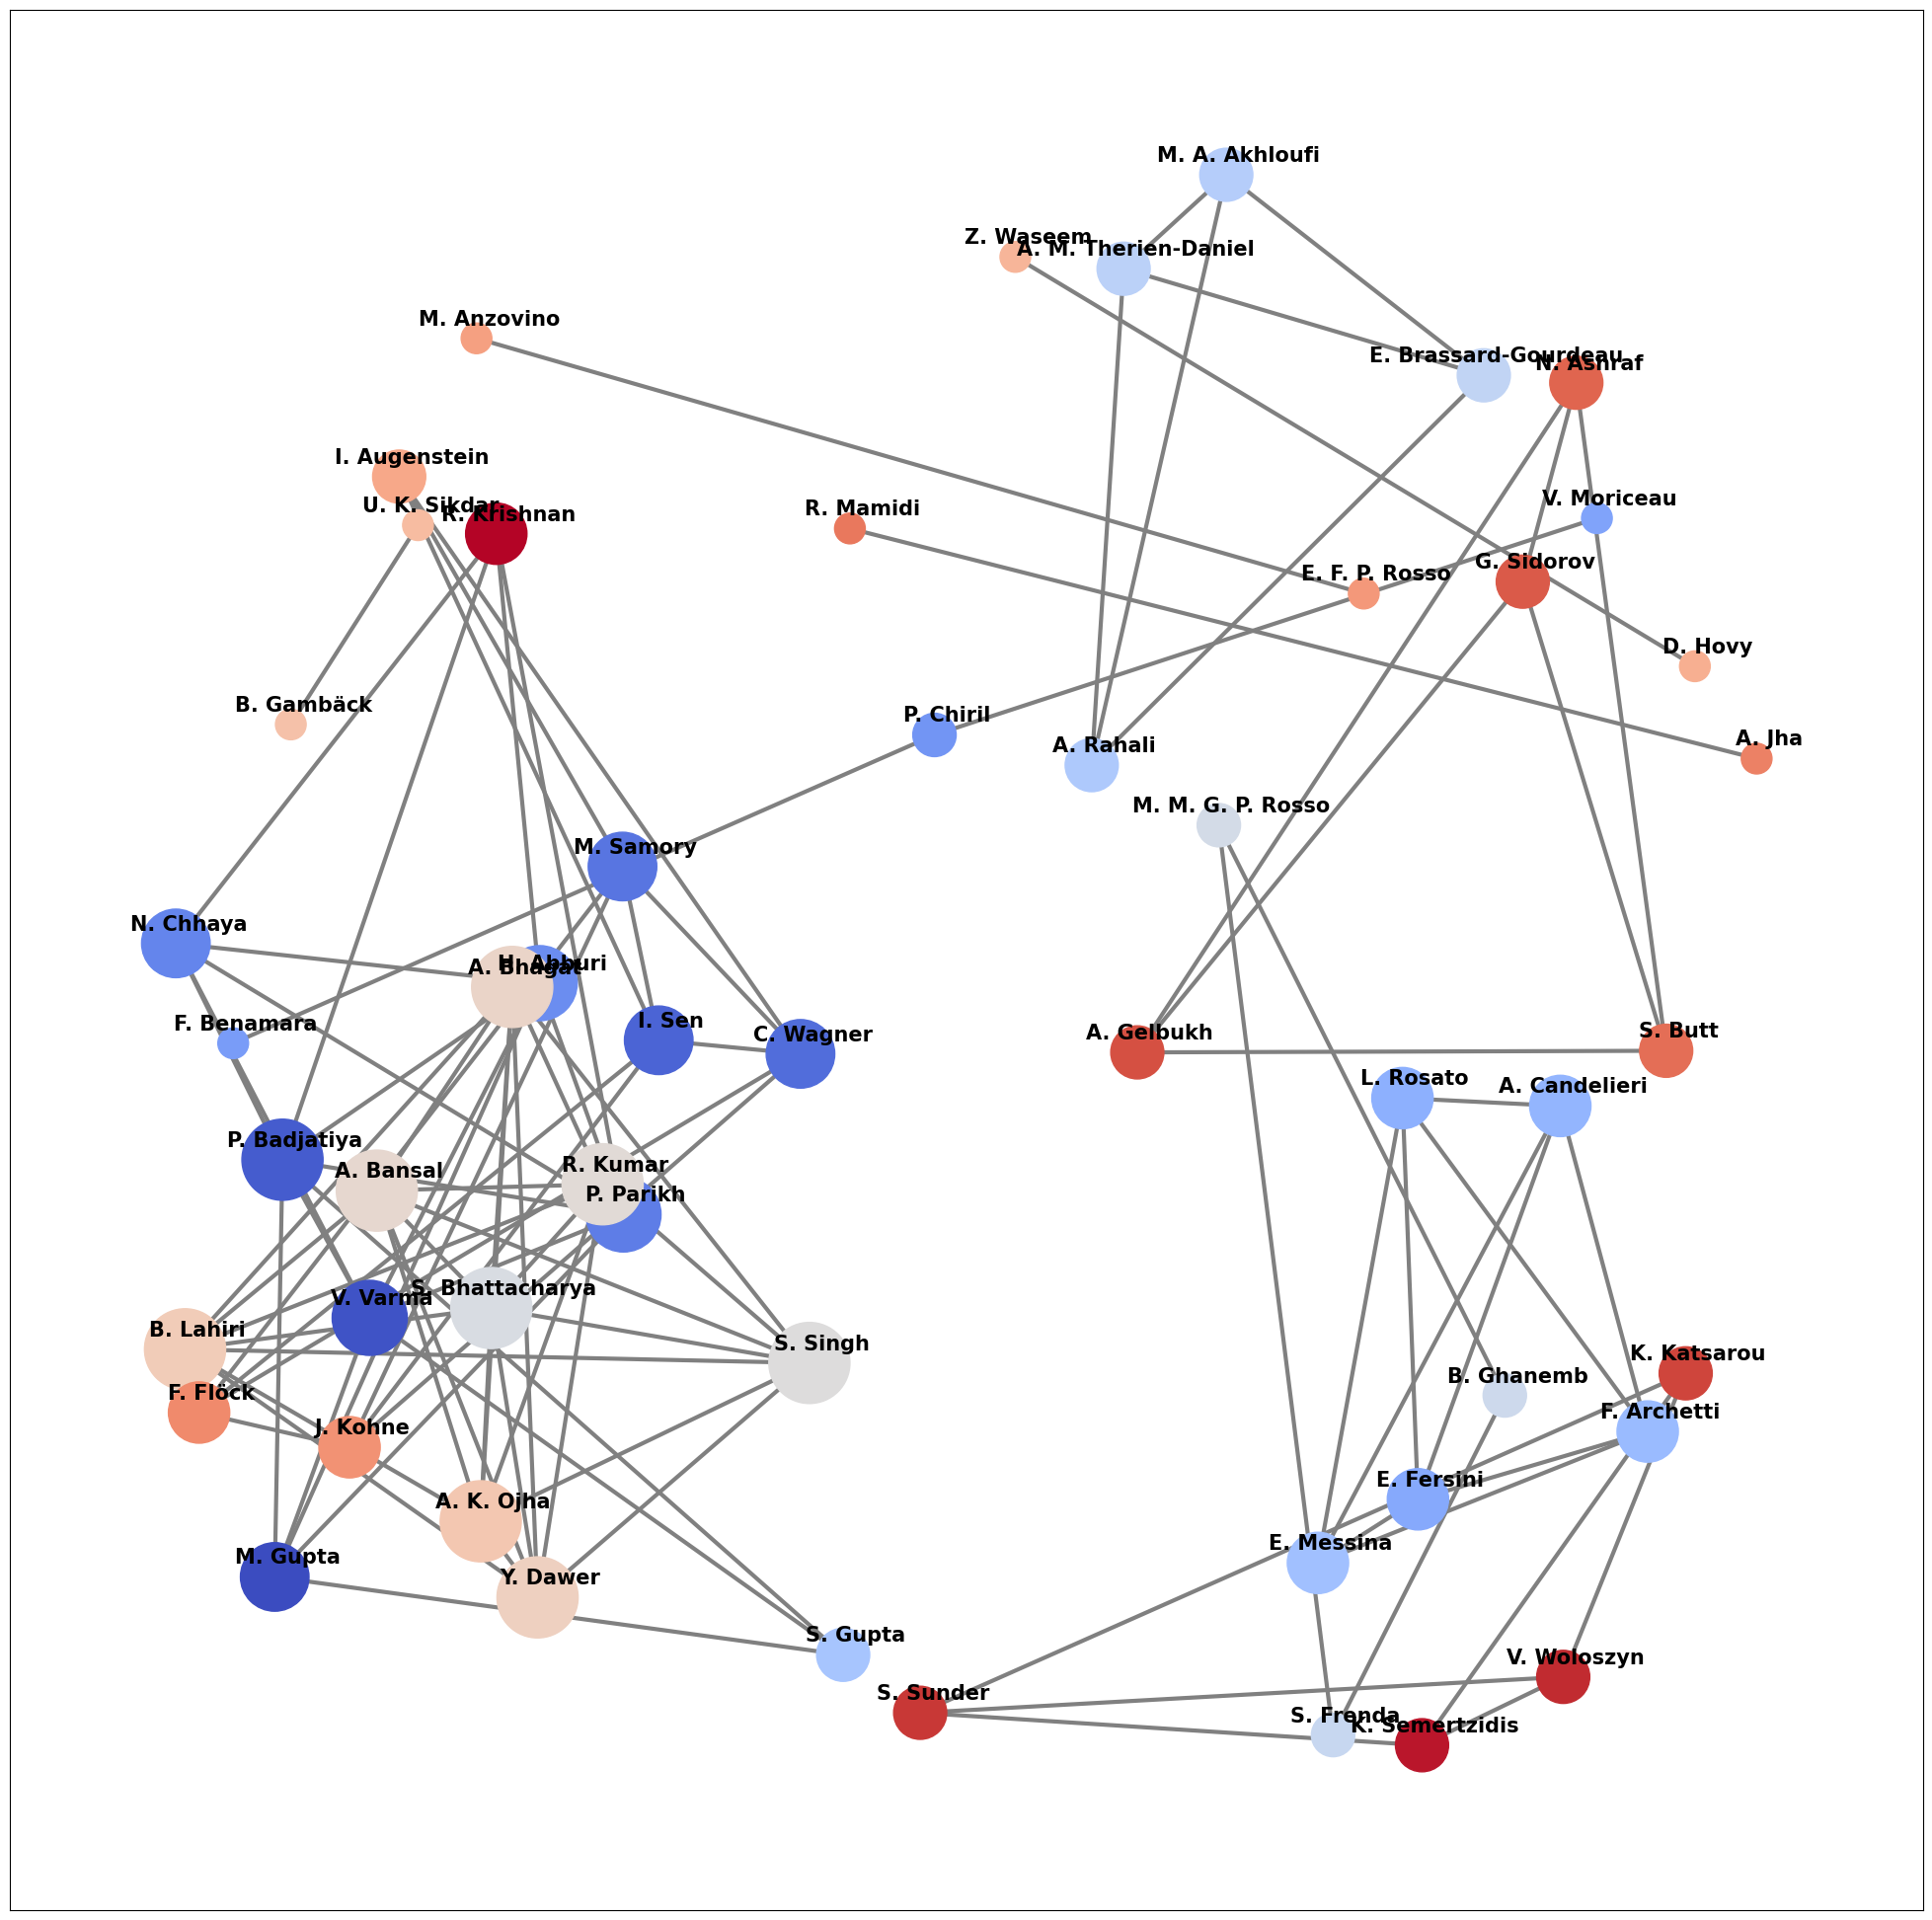

In [12]:
# Create dictionary of bigrams and their counts
d = data_paired_auth.set_index('auth_bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))
    # creating node size depending on node degree
    degree = dict(G.degree)

color_lookup = {k:v for v, k in enumerate(sorted(set(G.nodes())))}

low, *_, high = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)

fig, ax = plt.subplots(figsize=(25, 25))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=15,
                 width=3,
                 edge_color='grey',
                 node_color= [mapper.to_rgba(i) 
                    for i in color_lookup.values()],           #'purple',
                 nodelist=degree.keys(), node_size=[v * 500 for v in degree.values()],
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.015, value[1]+.015
    ax.text(x, y,
            s=key,
            #bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=15, weight='bold')

plt.show()

In [12]:
data['Platform of interest'] = data['Platform of interest'].astype(str).replace('nan',np.nan)

data['platform'] = np.where(data['Platform of interest'].str.contains('12', regex=True), data['Platform of interest'].str.replace("12", "Dialogues/scripts"), data['Platform of interest'])
data['platform'] = np.where(data['platform'].str.contains('10', regex=True), data['platform'].str.replace("10", "Gab"), data['platform'])
data['platform'] = np.where(data['platform'].str.contains('13', regex=True), data['platform'].str.replace("13", "Telegram"), data['platform'])
data['platform'] = np.where(data['platform'].str.contains('11', regex=True), data['platform'].str.replace("11", "Urban Dictionary"), data['platform'])
data['platform'] = np.where(data['platform'] == '7.1', 'Everyday Sexism Project', data['platform'])
data['platform'] = np.where(data['platform'].str.contains('8', regex=True), data['platform'].str.replace("8", "Work-related quotes"), data['platform'])
data['platform'] = np.where(data['platform'].str.contains('9', regex=True), data['platform'].str.replace("9", "Miscellaneous"), data['platform'])
data['platform'] = np.where(data['platform'].str.contains('4', regex=True), data['platform'].str.replace("4", "Reddit"), data['platform'])
data['platform'] = np.where(data['platform'].str.contains('3', regex=True), data['platform'].str.replace("3", "YouTube"), data['platform'])
data['platform'] = np.where(data['platform'].str.contains('2', regex=True), data['platform'].str.replace("2", "Facebook"), data['platform'])
data['platform'] = np.where(data['platform'].str.contains('1', regex=True), data['platform'].str.replace("1", "Twitter"), data['platform'])
data['platform'].unique()

array([nan, 'Twitter', 'YouTube', 'Everyday Sexism Project',
       'Twitter, Facebook, Reddit', 'Reddit',
       'Twitter, Work-related quotes, Miscellaneous', 'Twitter, Gab',
       'Urban Dictionary', 'Twitter, Dialogues/scripts',
       'Twitter, Facebook, YouTube, Telegram'], dtype=object)

In [13]:
data['Use case'].unique()

array([nan, 'Misogyny;\nNot misogyny',
       'Misogyny category detection:\n\n1. Discredit, \n2. sexual  harassment,  \n3. dominance,  \n4. derailing,  \n5. stereotype',
       'Racism;\nSexism;\nNeither',
       'Non-hate/ non-toxic (sentiment == “normal”);\nToxic (all other types of sentiments)',
       '1 -> Misogyny;\n0 -> Not misogyny',
       '1 -> Sexism;\n0 -> Ambiguous or neutral cases',
       'Gendered;\nNon-gendered', 'Misogyny (or sexism);\nNot misogyny',
       'Gendered or Misogynous;\nNon-gendered or Non-misogynous',
       'Sexism;\nRacism;\nBoth (racism & sexism);\nNon-hate speech',
       'Sexism;\nRacism;\nNone', 'Sexism;\nNot sexism',
       'Benevolent sexism; \nHostile sexism;\nOthers',
       'Sexism categorization:\n\n1. Misogyny and non-sexual violence,\n2. Non-sexist,  \n3. Stereotyping and dominance,  \n4. Objectification,  \n5. Ideological and inequality,\n6. Sexual violence',
       'Hate speech; \nNeutral;\nOffensive;\nPositive;\nSexism',
       '14 diff

In [14]:
data['Use case'] = data['Use case'].astype(str).replace('nan',np.nan)

data['classification_label'] = np.where((data['Use case'] == 'Misogyny;\nNot misogyny') | (data['Use case'] == '1 -> Misogyny;\n0 -> Not misogyny') | (data['Use case'] == 'Misogyny (or sexism);\nNot misogyny')  | (data['Use case'] == 'Misogynous defines if the template-generated\ntext is misogynous or non-misogynous:\nMisogyny;\nNon-misogyny') | (data['Use case'] == 'Misogyny (from the group type consisting of racism [because of ethnicity], misogyny and others)') | (data['Use case'] == 'Misogyny (from the group type consisting of racism [because of ethnicity], misogyny and others)'), 'Misogyny (binary)', data['Use case'])

data['classification_label'] = np.where((data['classification_label'] == '1 -> Sexism;\n0 -> Ambiguous or neutral cases') | (data['Use case'] == 'Sexism;\nNot sexism') | (data['Use case'] == 'Sexism; Not sexism'), 'Sexism (binary)', data['classification_label'])
data['classification_label'] = np.where((data['classification_label'] == 'Gender Stereotype GS (sexism); Non stereotype\nNot GS') | (data['classification_label'] == 'Gendered or Misogynous;\nNon-gendered or Non-misogynous') | (data['Use case'] == 'Gendered; \nNot Gendered') | (data['Use case'] == 'Misogyny;\nNot misogyny\n\nIf Misogyny, then:\nAggressive;\nNot aggressive') | (data['Use case'] == 'Gendered (GEN);\nNon-gendered (NGEN)') | (data['Use case'] == 'about/to/as Gender Classification:\nMasculine;\nFeminine;\nNeutral') | (data['Use case'] == 'about&to&as Gender Classification:\nMasculine;\nFeminine;\nNeutral') | (data['Use case'] == 'Gender Stereotype GS (sexism); Non stereotype') | (data['Use case'] == 'Gendered;\nNon-gendered'), 'Gender stereotype (binary)', data['classification_label'])
data['classification_label'] = np.where((data['classification_label'] == 'Hateful (Misogynistic and/or Xenophobic);\nNon-hateful') | (data['Use case'] == 'Non-hate/ non-toxic (sentiment == “normal”);\nToxic (all other types of sentiments)') | (data['Use case'] == 'Hateful;\nNon-hateful\n\n(In final stage)'), 'Hate (binary)', data['classification_label'])
data['classification_label'] = np.where((data['classification_label'] == '14 different categories of sexism:\n\n1. Role stereotyping;\n2. Attribute stereotyping;\n3. Body shaming;\n4. Hyper-sexualization (excluding body shaming);\n5. Internalized sexism;\n6. Hostile  work  environment;\n7. Denial or trivialisation of sexist misconduct;\n8. Threats;\n9. Sexual assault;\n10. Sexual harassment (excluding assault);\n11. Moral policing and victim blaming;\n12. Slut shaming;\n13. Motherhood  and  menstruation related discrimination;\n14. Other;'), 'Sexism (14 categories)', data['classification_label'])
data['classification_label'] = np.where((data['classification_label'] == '23 different categories of sexism:\n\n1. Role stereotyping          \n2. Attribute stereotyping          \n3. Body shaming          \n4. Hyper-sexualization (excluding body shaming)\n5. Internalized sexism          \n6. Pay gap          \n7. Hostile work environment (excluding pay gap)          \n8. Denial or trivialization of sexist misconduct\n9. Threats         \n10. Rape          \n11. Sexual assault (excluding rape)          \n12. Sexual harassment (excluding assault)\n13. Tone policing          \n14. Moral policing (excluding tone policing)          \n15. Victim blaming          \n16. Slut shaming\n17. Motherhood-related discrimination          \n18. Menstruation-related discrimination         \n19. Religion-based sexism     \n20. Physical violence          \n21. Mansplaining         \n22. Gaslighting          \n23. Other'), 'Sexism (23 categories)', data['classification_label'])
data['classification_label'] = np.where((data['classification_label'] == 'Sexism categorization:\n\n1. Misogyny and non-sexual violence,\n2. Non-sexist,  \n3. Stereotyping and dominance,  \n4. Objectification,  \n5. Ideological and inequality,\n6. Sexual violence') , 'Sexism (5 categories)', data['classification_label'])
data['classification_label'] = np.where((data['classification_label'] == 'Misogyny category detection:\n1. Neosexism\n2. Discredit, \n3. Sexual  harassment,  \n4. Dominance,  \n5. Benevolent sexism,  \n6. Stereotypes & Objectification') | (data['classification_label'] == 'Misogyny category detection:\n\n1. Discredit, \n2. sexual  harassment,  \n3. dominance,  \n4. derailing,  \n5. stereotype\n\nTarget classification:\nActive;\nPassive') | (data['classification_label'] == 'Misogyny category detection:\n\n1. Discredit, \n2. sexual  harassment,  \n3. dominance,  \n4. derailing,  \n5. stereotype'), 'Misogyny (5 categories)', data['classification_label'])
data['classification_label'] = np.where((data['classification_label'] == 'Topics computationally and annotated qualitatively for n=7:\n1. Public space/ Street harassment\n2. Online/ Comments\n3. Work/office /company/ customer\n4. Transport/ Street harassment\n5. School/ Teacher/ Uniform\n6. Media\n7. Domestic abuse/ Relationships/Home') | (data['classification_label'] == 'Topics computationally and annotated qualitatively for n=20:\n1. Socialising\n2. Work\n3. Comments\n4. Domestic Abuse\n5. Feminism\n6. Other\n7. Customer / Workplace\n8. Titles, forms of address\n9. Workplace / Parenting / Home\n10. Sport / Media\n11. Street Harassment (verbal)\n12. University\n13. Home / Families\n14. School\n15. Social media / Media\n16. Clothing / Appearance\n17. Street Harassment (role expectancy)\n18. Street Harassment (threatened)\n19. Assault / Violence\n20. Public Transport'), 'Topics of sexism \n(unsupervised)' , data['classification_label'])
data['classification_label'] = np.where((data['classification_label'] == 'Sexism;\nRacism;\nBoth (racism & sexism);\nNon-hate speech') | (data['classification_label'] == 'Sexism;\nRacism;\nBoth (racism & sexism);\nNon-hate speech') | (data['classification_label'] == 'Sexism;\nRacism;\nNone') | (data['classification_label'] == 'Racism;\nSexism;\nNeither') | (data['classification_label'] == 'Misogyny (from the group type consisting of racism [because of ethnicity], misogyny and others)'), 'Sexism w/o Racism' , data['classification_label'])
data['classification_label'] = np.where((data['classification_label'] == 'Complimentary categories of sexism:\n(1) indirect  harassment;\n(2)  information  threat;\n(3) sexual  harassment; \n(4) physical  harassment. '), 'Complimentary Sexism (4 categories)', data['classification_label'])
data['classification_label'] = np.where((data['classification_label'] == 'Sexism detection: \n1. Direct;\n2. Descriptive;\n3. Reporting;\n4. Non sexist\n\nStereotype detection:\n1. Physical;\n2. Behavioural;\n3. Activities') | (data['classification_label'] == 'Type of sexism: \n1. Direct;\n2. Descriptive;\n3. Reporting;\n4. Non sexist') | (data['classification_label'] == 'Direct sexism (sexist content);\nDescriptive sexism (sexist content);\nReporting sexism (sexist content);\nNot sexist content'), 'Direct/Indirect Sexism', data['classification_label'])
data['classification_label'] = np.where((data['classification_label'] == 'Stereotype detection:\n1. Physical;\n2. Behavioural;\n3. Activities') | (data['classification_label'] == 'Type of stereotype:\nPhysical;\nBehavioural;\nActivities'), 'Stereotype', data['classification_label'])
data['classification_label'] = np.where((data['classification_label'] == 'Target:\n1. Individual= Person-targeted,\n2. Group= Group-targeted,\n3. Others= e.g., conceptual against media, a political party,\n4. Untargeted= Profanity/Swearing;'), 'Targeted/Untargeted', data['classification_label'])
data['classification_label'] = np.where((data['classification_label'] == 'Benevolent sexism; \nHostile sexism;\nOthers'), 'Ambivalent sexism', data['classification_label'])
data['classification_label'] = np.where((data['classification_label'] == 'Abusive; \nNot abusive') | (data['classification_label'] == 'Aggression analysis:\n\nAggressive;\nGender biased;\nCommunally charged'), 'Abuse/Agression', data['classification_label'])

data['classification_label'].unique()

array([nan, 'Misogyny (binary)', 'Misogyny (5 categories)',
       'Sexism w/o Racism', 'Hate (binary)', 'Sexism (binary)',
       'Gender stereotype (binary)', 'Ambivalent sexism',
       'Sexism (5 categories)',
       'Hate speech; \nNeutral;\nOffensive;\nPositive;\nSexism',
       'Sexism (14 categories)', 'Sexism (23 categories)',
       'Topics of sexism \n(unsupervised)',
       'Complimentary Sexism (4 categories)', 'Stereotype',
       'Direct/Indirect Sexism', 'Abuse/Agression', 'Targeted/Untargeted'],
      dtype=object)

In [15]:
data['Model Architechture'] = data['Model Architechture'].apply(lambda x: str(x).replace('+', ','))

In [16]:
data['Model Architechture'].unique()

array(['nan', 'BERT, Unbiased SVM', 'USE , Unbiased SVM',
       'CNN , Random Embedding', 'CNN , GloVe',
       'FastText , Random Embedding', 'FastText , GloVe',
       'LSTM , Random Embedding', 'LSTM , GloVe',
       'CNN , Random Embedding , GBDT', 'CNN , GloVe  , GBDT',
       'FastText , Random Embedding  , GBDT', 'FastText , GloVe  , GBDT',
       'LSTM , Random Embedding  , GBDT', 'LSTM , GloVe  , GBDT',
       'Proposed model:\n\n[[[f3(TFIDF ngrams) , f2(Lexical features)] x MLP layer (16)] , [f1(Word2Vec embeddings) x BiLSTM layer x Attention layer x MLP layer (16)]] x MLP layer (8)',
       'SVM (RBF kernel) , NLTK , (char , word) n-gram TF-IDF , Information Gain',
       'Character n-gram , SVM', 'Word n-gram , Character n-gram , SVM',
       'CNN , Random vectors', 'CNN , word2vec',
       'CNN , character n-grams', 'CNN , word2vec , character n-grams',
       'Logistic Regression', 'Logistic Regression , character n-grams',
       'Logistic Regression , character n-grams

In [17]:
data['model'] = ''

data['model'] = np.where(data['Model Architechture'].str.contains('LR|Logistic Regression|logistic regression|Logistic regression'), data['model']+ ', LR', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('RF|Random Forest|random forest|Random forest'), data['model'] + ', RF', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('SVM|Support Vector Machine|support vector machine'), data['model'] + ', SVM', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('BERT|RoBERTa|tBERT|FlauBERT|AngryBERT|XLM-R|mBERT|XLMRoBERTa|BERT-base'), data['model'] + ', BERT', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('CNN'), data['model'] + ', CNN', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('NB|Naïve Bayes|Naïve-Bayes|MNB|Multinomial Naive Bayes|Naive Bayes|MultinomialNB'), data['model'] + ', NB', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('BiLSTM|LSTM|Bi-LSTM'), data['model'] + ', LSTM', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('word2vec|GloVe|Word2Vec'), data['model'] + ', W2V', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('LDA'), data['model'] + ', LDA', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('Gradient Boosting|CatBoost|GBDT'), data['model'] + ', GB', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('DT|DT- TFunigrams|DT- TFbigrams'), data['model'] + ', DT', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('GCN'), data['model'] + ', GCN', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('DNN'), data['model'] + ', DNN', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('RNN'), data['model'] + ', RNN', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('XGBoost'), data['model'] + ', XGB', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('k-NearestNeighbours|kNN'), data['model'] + ', kNN', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('BoW|Bag-of-words'), data['model'] + ', BoW', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('Ridge Classifier|RC'), data['model'] + ', RC', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('n-grams|unigram|bigram|TFunigrams|TFbigrams'), data['model'] + ', n-grams', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('Information Gain'), data['model'] + ', IG', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('MLP'), data['model'] + ', MLP', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('FastText|Embedding|USE|USE_T|Universal Sentence Encoder|InferSent'), data['model'] + ', Embeddings', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('One-vs-Rest|OVR'), data['model'] + ', OVR', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('GRU|Bi-GRU'), data['model'] + ', GRU', data['model'])
data['model'] = np.where(data['Model Architechture'].str.contains('Lexicon'), data['model'] + ', Lexicon-based', data['model'])


data['model'].value_counts()

                                  102
, BERT                             57
, LR                               22
, SVM, n-grams                     15
, SVM                              13
                                 ... 
, SVM, BoW                          1
, RF, BoW                           1
, BERT, CNN, W2V                    1
, NB, BoW                           1
, LR, SVM, W2V, DT, Embeddings      1
Name: model, Length: 84, dtype: int64

In [18]:
data['platform'] = data['platform'].astype(str)
data['classification_label'] = data['classification_label'].astype(str)

In [19]:
platf_df = data.groupby(['Study ID'])['platform'].agg(', '.join).apply(pd.Series).reset_index().rename(columns={0: 'platforms'})
class_df = data.groupby(['Study ID'])['classification_label'].agg(', '.join).apply(pd.Series).reset_index().rename(columns={0: 'classification'})
class_df

,Study ID,classification
0,1.0,Misogyny (binary)
1,2.0,Sexism w/o Racism
2,3.0,Misogyny (binary)
3,4.0,Misogyny (binary)
4,5.0,Gender stereotype (binary)
5,6.0,Sexism w/o Racism
6,7.0,Sexism w/o Racism
7,8.0,Sexism w/o Racism
8,9.0,Sexism (binary)
9,10.0,Misogyny (5 categories)


In [20]:
mod_df =data.groupby(['Study ID'])['model'].agg(', '.join).apply(pd.Series).reset_index().rename(columns={0: 'models'})
mod_df['models'] = mod_df['models'].apply(lambda x: x.lstrip(', '))
mod_df = mod_df.replace(r'^\s*$', np.nan, regex=True)
mod_df

,Study ID,models
0,1.0,"SVM, BERT"
1,2.0,"CNN, Embeddings"
2,3.0,"LSTM, W2V, MLP"
3,4.0,"SVM, IG"
4,5.0,SVM
5,6.0,CNN
6,7.0,LR
7,8.0,"LR, n-grams"
8,9.0,BERT
9,10.0,"RF, n-grams"


In [21]:
df = pd.merge(platf_df, class_df, on='Study ID', how='left')
df = pd.merge(df, mod_df, on='Study ID', how='left')
df = df.dropna()
df

,Study ID,platforms,classification,models
0,1.0,Twitter,Misogyny (binary),"SVM, BERT"
1,2.0,Twitter,Sexism w/o Racism,"CNN, Embeddings"
2,3.0,Twitter,Misogyny (binary),"LSTM, W2V, MLP"
3,4.0,Twitter,Misogyny (binary),"SVM, IG"
4,5.0,YouTube,Gender stereotype (binary),SVM
5,6.0,Twitter,Sexism w/o Racism,CNN
6,7.0,Twitter,Sexism w/o Racism,LR
7,8.0,Twitter,Sexism w/o Racism,"LR, n-grams"
8,9.0,Twitter,Sexism (binary),BERT
9,10.0,Twitter,Misogyny (5 categories),"RF, n-grams"


In [22]:
df['platforms'] = df['platforms'].apply(lambda x: x.split(","))
df['models'] = df['models'].apply(lambda x: x.split(","))

In [23]:
type(df['classification'].iloc[0])

str

In [24]:
'''(df.set_index(['classification']) 
       .apply(lambda col: col.str.split(','))
       .explode(['platforms', 'models'])
       .reset_index()
       .reindex(df.columns, axis=1))'''

"(df.set_index(['classification']) \n       .apply(lambda col: col.str.split(','))\n       .explode(['platforms', 'models'])\n       .reset_index()\n       .reindex(df.columns, axis=1))"

In [25]:
for col in ['platforms', 'models']:
    df = df.explode(col)

df

,Study ID,platforms,classification,models
0,1.0,Twitter,Misogyny (binary),SVM
0,1.0,Twitter,Misogyny (binary),BERT
1,2.0,Twitter,Sexism w/o Racism,CNN
1,2.0,Twitter,Sexism w/o Racism,Embeddings
2,3.0,Twitter,Misogyny (binary),LSTM
...,...,...,...,...
39,40.0,Telegram,Gender stereotype (binary),XGB
40,41.0,Twitter,Gender stereotype (binary),LR
40,41.0,Twitter,Gender stereotype (binary),BERT
40,41.0,Twitter,Gender stereotype (binary),LSTM


In [26]:
#creation of individual data frame 
#1-[platforms]=>[classification]
df1 = df.groupby(['platforms', 'classification'])['Study ID'].count().reset_index()
df1.columns = ['source', 'target', 'value']
#df1['source'] =df1['source'].map({'S':'Southampton', 'Q': 'Queenstown', 'C': 'Cherbourg'})
#df1['target'] =df1['target'].map({1: 'Pclass1', 2: 'Pclass2', 3: 'Pclass3'})

#2-[Pclass]=>[Sex]
df2 = df.groupby(['classification', 'models'])['Study ID'].count().reset_index()
df2.columns = ['source', 'target', 'value']

#full data generated using 
all_links = pd.concat([df1, df2], axis=0)

#for using with 'label' parameter in plotly 
#https://sparkbyexamples.com/pandas/pandas-find-unique-values-from-columns
unique_source_target = list(pd.unique(all_links[['source', 'target']].values.ravel('K')))

#for assigning unique number to each source and target
mapping_dict = {k: v for v, k in enumerate(unique_source_target)}

#mapping of full data
all_links['source'] = all_links['source'].map(mapping_dict)
all_links['target'] = all_links['target'].map(mapping_dict)

#converting full dataframe as list for using with in plotly
links_dict = all_links.to_dict(orient='list')

#Sankey Diagram Code 
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = unique_source_target,
      
    ),
    link = dict(
      source = links_dict["source"],
      target = links_dict["target"],
      value = links_dict["value"],
  
  ))])

fig.add_annotation(text='<b>Source of <br>online data</b>',
            align='left',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=1.1,
            xanchor="left",
            font_size=12
            )

fig.add_annotation(text='<b>Sexism/misogyny <br>classification type</b>',
            align='left',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0.40,
            y=1.1,
            xanchor="left",
            font_size=12
            )

fig.add_annotation(text='<b>Model used</b>',
            align='left',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0.9,
            y=1.1,
            xanchor="left",
            font_size=12
            )

fig.update_layout(title_text="<b>Type of sexism/misogyny studied using various computational methods, based on different sources of online data</b>", font_size=10,width=1000, height=600)
fig.show()

#On hovering mouse over the diagram more details are visible

In [29]:
#fig.write_image('sankey_plot_plat_cla_mod.pdf')